# Libraries

In [12]:
import shutup
import pandas as pd
import numpy as np
import os as os
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import PoissonRegressor

# Load train data

- iterate through train data folder 
- feature engineer the **country** and **league** from parent folder name
- join the loaded csv files by rows
- removed quotation marks that would in some rows merge two columns into one

In [13]:
def replace_last(string, old, new):
    return new.join(string.rsplit(old, 1))

def delete_quotation_marks(path):
    with open(path, "r") as f:
        raw_file = f.readlines()
        count=0
        for i in range(len(raw_file)):
            match = re.search("\"(\+|-)?\d+\.?\d*,(\+|-)?\d+\.?\d*\"", raw_file[i])
            if match:
                count+=1
                raw_file[i] = raw_file[i].replace("\"","")
                raw_file[i] = replace_last(raw_file[i], ",","\n")
    with open(path, "w") as f:
        f.writelines(raw_file)

In [14]:
### Load train data
df = pd.DataFrame()
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            # Remove empty rows and columns
            tmp = tmp.dropna(how='all', axis=0)
            tmp = tmp.dropna(how='all', axis=1)
            # Derive additional columns
            tmp["league"] = int(root.split("\\")[2])
            tmp["country"] = root.split("\\")[1]
            tmp["season"] = int(file[:2]) # no. of season - 00/01 - 0th season, 21/22 - 21st season
            df = pd.concat([df, tmp], axis = 0)
df.sort_values(by="Date", inplace=True)

### Load test data
df_test = pd.DataFrame()
for root, directory, files in os.walk("data/test", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            # Remove empty rows and columns
            tmp = tmp.dropna(how='all', axis=0)
            tmp = tmp.dropna(how='all', axis=1)
            # Derive additional columns
            tmp["league"] = int(root.split("\\")[2])
            tmp["country"] = root.split("\\")[1]
            tmp["season"] = 22 # no. of season - 00/01 - 0th season, 21/22 - 21st season
            # tmp["orig_index"] = tmp.index
            df_test = pd.concat([df_test, tmp], axis = 0)

df = pd.concat([df, df_test], axis=0, join="outer")

In [15]:
df.to_csv("combined.csv")

In [16]:
delete_quotation_marks("combined.csv")

In [17]:
shutup.please()
df = pd.read_csv("combined.csv")

# Data validation

In some cases, the data is wrong. This section corrects the loaded data.

## Same name for different things

In some cases, columns are named differently. We will standardize to use column names that are in *'notes.txt'*


In [18]:
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            if "HT" in tmp.columns:
                print(f"Cases for HT: {root}, {file}")
            if "AT" in tmp.columns:
                print(f"Cases for AT: {root}, {file}")

Cases for HT: data/train\greece\1, 0001.csv
Cases for AT: data/train\greece\1, 0001.csv
Cases for HT: data/train\greece\1, 0102.csv
Cases for AT: data/train\greece\1, 0102.csv
Cases for HT: data/train\greece\1, 0203.csv
Cases for AT: data/train\greece\1, 0203.csv
Cases for HT: data/train\greece\1, 0304.csv
Cases for AT: data/train\greece\1, 0304.csv
Cases for HT: data/train\greece\1, 0405.csv
Cases for AT: data/train\greece\1, 0405.csv


The only affected data are in Greece.

In [19]:
df["HomeTeam"] = df["HomeTeam"].mask(df["HT"].notnull(), df["HT"])
df["AwayTeam"] = df["AwayTeam"].mask(df["AT"].notnull(), df["AT"])
df = df.drop(columns = ["HT", "AT"])

In [20]:
df.drop(df[df["HomeTeam"] == df["AwayTeam"]].index, inplace=True) # remove cases where teams play against themselves

In [21]:
# df["Date"] = pd.to_datetime(df["Date"], format = '%d/%m/%Y', dayfirst=True)

## Not imputable data

In some cases, missing data cause the data to be unusable and can't be computed. This applies to variables

- HomeTeam
- AwayTeam

In [22]:
crucial_cols = ['Date', 'HomeTeam', 'AwayTeam']
df = df.dropna(subset = crucial_cols)

In [23]:
df[["HFKC", "AFKC"]].describe()

,HFKC,AFKC
count,1305.000000,1305.000000
mean,16.627586,17.283525
std,4.386871,4.735901
min,2.000000,2.000000
25%,14.000000,14.000000
50%,16.000000,17.000000
75%,20.000000,20.000000
max,32.000000,34.000000


## Goal validation

Some goals are incorrect and they need to be fixed.



In [24]:
goal_cols = ["FTHG", "FTAG", "HTHG", "HTAG"]
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,154495.000000,154473.000000,154445.000000,154454.000000
mean,2.217761,1.131447,0.655308,0.494315
std,21.887856,1.108842,0.809085,0.708314
min,0.000000,-1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,998.000000,13.000000,7.000000,6.000000


There seem to be several issues:

- the max value for **FTHG** is absurd
- the min value for **FTAG** does not make sense
- some values are missing

In [25]:
df["FTHG"].value_counts().head(15)

FTHG
1.0      51639
2.0      37642
0.0      36011
3.0      18462
4.0       7202
5.0       2343
6.0        751
7.0        185
8.0         42
9.0         14
339.0        5
10.0         5
373.0        4
772.0        4
572.0        4
Name: count, dtype: int64

First, we will remove all rows where the Full Time Home Goals are greater than 15.

In [26]:
df_22 = df[df["season"] == 22] # this split is necessary as goal values are unknown for test season
df = df[df["FTHG"] <= 15] # this line gets also rid of all NaNs
df = pd.concat([df, df_22])

Next, all Full Time Away goals that are less than zero are inspected. Since we are not sure which values are good and bad, all of them are removed.

In [27]:
# df_22 = df[df["season"] == 22] # keep season 22
df = df[df["FTAG"] >= 0]
df = pd.concat([df, df_22])

In [28]:
df["FTHG"].isna().sum() # there should be 7277, which is the count of rows in season 22

7277

In [29]:
df["FTAG"].isna().sum()

7277

What's left are the missing values in 'HTHG' and 'HTAG' columns. We have no way of recomputing these as well and these rows are again excluded.

In [30]:
cols = ["HTHG", "HTAG"]
df_22 = df[df["season"] == 22]
# df_pre22 = df[df["season"] != 22]
df = df[df[cols].isna().sum(axis=1) == 0]
df = pd.concat([df, df_22], axis=0)
# df["season"].unique()

If we run the describe() function again, we can see that the counts in all columns match and min/max statistics make sense.

In [31]:
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,153834.000000,153834.000000,153834.000000,153834.000000
mean,1.485536,1.133768,0.655369,0.494481
std,1.253200,1.107155,0.809073,0.708545
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,10.000000,13.000000,7.000000,6.000000


### Shots on target imputation

In [32]:
lm = PoissonRegressor()

y_train = df[df["season"] != 22][["AST", "HST"]]
X_train = df[df["season"] != 22][["AST", "HST", "FTAG", "FTHG"]]
X_train.dropna(subset=["AST", "HST"],axis=0, inplace=True, how='any')
y_train.dropna(axis=0, inplace=True, how='any')

In [33]:
X_train = pd.concat([X_train["FTAG"],X_train["FTHG"]], axis=0)
y_train = pd.concat([y_train["AST"], y_train["HST"]], axis=0)

X_train = np.array(X_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

In [34]:
lm.fit(X_train, y_train)

PoissonRegressor()

In [35]:
X_pred_HST = df[(df["season"] != 22) & (df["HST"].isna())][["HST", "FTHG"]]

X_pred_AST = df[(df["season"] != 22) & (df["AST"].isna())][["AST", "FTAG"]]

In [36]:
X_pred_AST =   np.array(X_pred_AST["FTAG"]).reshape(-1,1)
X_pred_HST =  np.array(X_pred_HST["FTHG"]).reshape(-1,1)


In [37]:
y_pred_HST = lm.predict(X_pred_HST)
y_pred_AST = lm.predict(X_pred_AST)

In [38]:
X_pred_HST = df[df["season"]!= 22][["HST", "FTHG"]]
X_pred_AST = df[df["season"]!= 22][["AST", "FTAG"]]
X_pred_HST = X_pred_HST[X_pred_HST.isna().any(axis=1)]
X_pred_AST = X_pred_AST[X_pred_AST.isna().any(axis=1)]

In [39]:
X_pred_AST["AST"] = y_pred_AST
X_pred_HST["HST"] = y_pred_HST

In [40]:
X_pred_HST

,HST,FTHG
49,4.342496,1.0
54,5.213597,2.0
55,5.213597,2.0
64,5.213597,2.0
69,6.259441,3.0
...,...,...
154779,4.342496,1.0
154780,5.213597,2.0
154781,5.213597,2.0
154782,3.616940,0.0


In [41]:
df[(df["season"] != 22) & (df["HST"].isna())]["HST"]

49       NaN
54       NaN
55       NaN
64       NaN
69       NaN
          ..
154779   NaN
154780   NaN
154781   NaN
154782   NaN
154786   NaN
Name: HST, Length: 63098, dtype: float64

In [42]:
df.loc[(df["season"] != 22) & (df["AST"].isna()), "AST"] = X_pred_AST["AST"]
df.loc[(df["season"] != 22) & (df["HST"].isna()), "HST"] = X_pred_HST["HST"]

In [43]:
df[df["season"] != 22]["HST"]

0         5.0
2         8.0
3         6.0
4         6.0
5         3.0
         ... 
154801    0.0
154802    6.0
154803    4.0
154804    2.0
154805    4.0
Name: HST, Length: 153834, dtype: float64

## Result validation

Another thing that needs to be validated is the result classification, which are re-classified - this is the easiest data validation process.

In [44]:
half_conds = [df["HTHG"] > df["HTAG"], df["HTHG"] < df["HTAG"], df["HTHG"] == df["HTAG"]]
half_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "HTR"] = np.select(half_conds, half_choic)
full_conds = [df["FTHG"] > df["FTAG"], df["FTHG"] < df["FTAG"], df["FTHG"] == df["FTAG"]]
full_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "FTR"] = np.select(full_conds, full_choic)

## Validation of other statistics

First step is to look at simple descriptive statistics.

In [45]:
stat_cols = [
    'Attendance', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW',
    'HC', 'AC', 'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', "HBP", "ABP"
]

df[stat_cols].describe()

,Attendance,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,...,HFKC,AFKC,HO,AO,HY,AY,HR,AR,HBP,ABP
count,6641.000000,91641.000000,91683.000000,153834.000000,153834.000000,6472.000000,6484.000000,91235.000000,91286.000000,89606.000000,...,1298.000000,1298.000000,6485.000000,6466.000000,91834.000000,91831.000000,91854.000000,91799.000000,6652.000000,6639.000000
mean,12853.621894,12.675691,10.296674,5.092346,4.338688,0.351823,0.260950,5.722694,4.647372,12.849296,...,16.620955,17.298921,3.258288,3.250541,1.642714,1.960275,0.086964,0.119936,15.496843,20.928604
std,13873.200798,4.925237,4.384018,2.314043,2.006212,0.610765,0.543137,2.937960,2.624308,4.555750,...,4.394704,4.740125,2.368060,2.519042,1.292988,1.365244,0.299356,0.351835,14.991016,17.225443
min,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3530.000000,9.000000,7.000000,3.616940,3.000000,0.000000,0.000000,4.000000,3.000000,10.000000,...,14.000000,14.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000
50%,7014.000000,12.000000,10.000000,5.000000,4.342496,0.000000,0.000000,5.000000,4.000000,12.000000,...,16.000000,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,0.000000,10.000000,20.000000
75%,17608.000000,16.000000,13.000000,6.000000,5.213597,1.000000,0.000000,7.000000,6.000000,16.000000,...,20.000000,20.000000,5.000000,5.000000,2.000000,3.000000,0.000000,0.000000,20.000000,30.000000
max,69000.000000,46.000000,45.000000,27.000000,23.000000,4.000000,10.000000,26.000000,21.000000,145.000000,...,32.000000,34.000000,16.000000,18.000000,11.000000,10.000000,3.000000,9.000000,115.000000,150.000000


Then we take a look at boxplots for variables where at least one variable falls out of the interval

$$
(\text{q}_{0.25} - 3 * \text{IQR} ; \text{q}_{0.75} + 3 * \text{IQR})
$$

In [46]:
def outliers(x, multi = 3):
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    iqr = q75 - q25
    outliers = x[(x < q25 - multi * iqr) | (x > q75 + multi * iqr)]
    return len(outliers)

stat_outliers = df[stat_cols].apply(lambda x: outliers(x))
stat_outliers = stat_outliers[stat_outliers != 0]
stat_outliers

Attendance      109
HS               14
AS               23
HST             879
AST             863
AHW            1435
HC              174
AC               72
HF               21
AF               25
HO                4
AO                2
HY              632
AY                2
HR             7542
AR            10247
HBP              13
ABP              24
dtype: int64

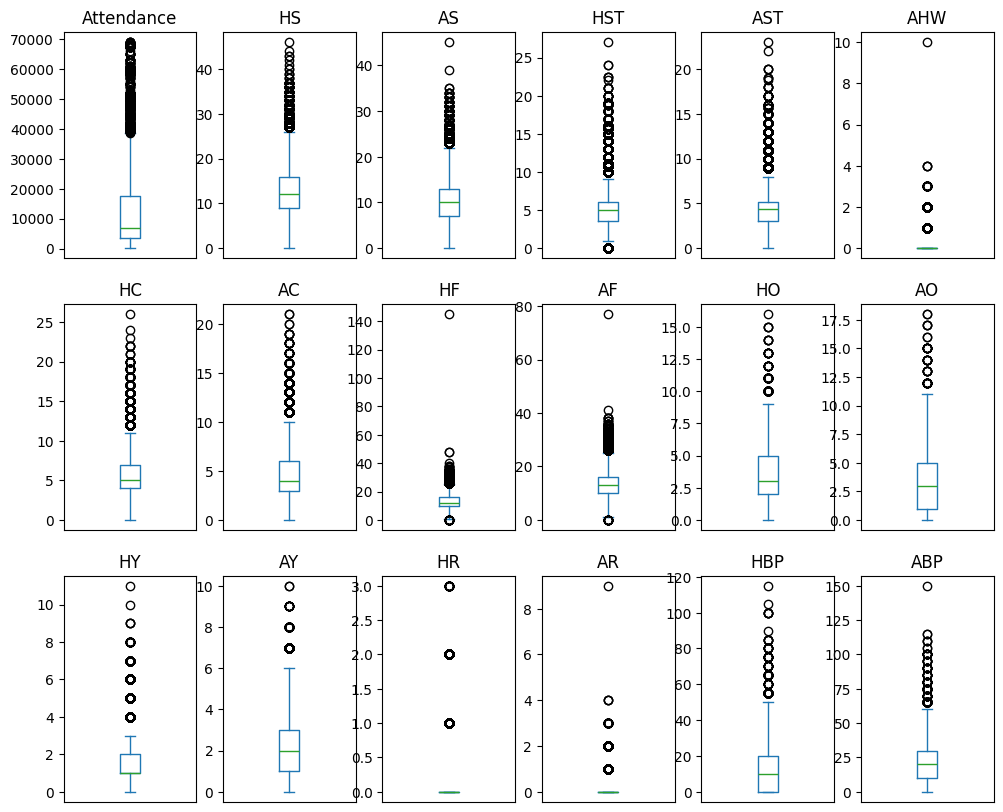

In [47]:
fig, axes = plt.subplots(nrows=3, ncols = 6, figsize = (12, 10))
axes = axes.ravel()

for i, col in enumerate(stat_outliers.index):
    # Data
    df[col].plot(kind='box', ax = axes[i])
    # Styling
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()


We can se that some outliers are not that extreme. For example variables *HO*, *AO* or *HY* have extreme values, but won't remove them. This is because even tho they can be considered as extreme, there seems to be a natural way how they occured and tehre are no huge jumps between them.

On the other hand, variables *AHW*, *HF*, *AF* and *AR* seem to have some variables that are far away from the other data. Note that we do not consider variables in *HR* as outliers because it looks like it's a discrete variable with mostly zeroes.

In [48]:
stat_jump = [
    "AS", "AHW", "HF", "AF", "AR", "ABP"
]
stats_cut = [
    38, 6, 100, 60, 6, 130
]

print("Number of extreme values:")
for i, col in enumerate(stat_jump):
    cutoff = stats_cut[i]
    x = df[col].to_numpy()
    extreme = x[x > cutoff]
    print(f"{col}: {extreme}, (count: {len(extreme)})")
    
plt.show()

Number of extreme values:
AS: [45. 39.], (count: 2)
AHW: [10.], (count: 1)
HF: [145.], (count: 1)
AF: [77.], (count: 1)
AR: [9.], (count: 1)
ABP: [150.], (count: 1)


Based on the analysis, we see that these extreme values occur at most twice. This is why we chose to remove them.

In [49]:
criteria = dict(zip(stat_jump, stats_cut))
for column, value in criteria.items():
    # .isna() is important because otherwise all na rows are dropped
    df = df[df[column].lt(value) | df[column].isna()]

Finally, we will double-check with boxplots.

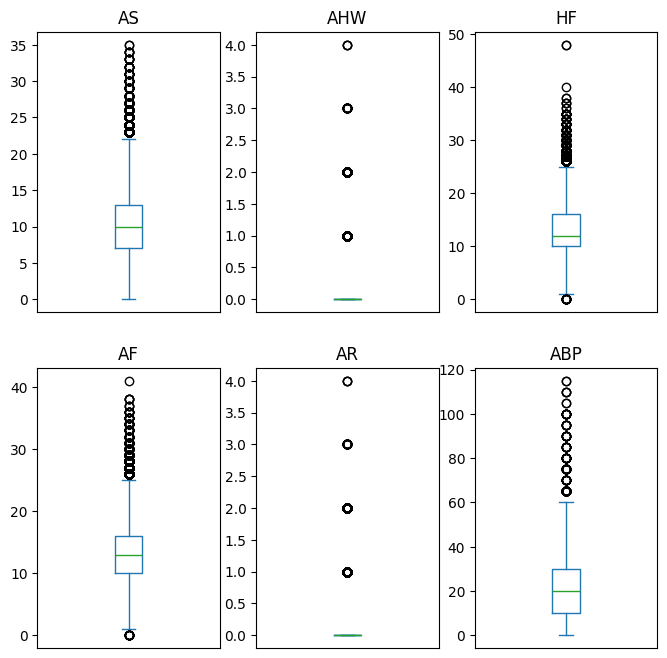

In [50]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize = (8, 8))
axes = axes.ravel()

for i, col in enumerate(stat_jump):
    df[col].plot(kind='box', ax = axes[i])
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()

IT looks like variable *HF* contains another outlier, but this process should be done only once. Hence, no outliers are removed.

## Random unnamed data

File *'data/train/portugal/1/0304.csv'* contains random data in columns *'Unnamed: 33'* and *'Unnamed: 34'*.

In [51]:
unnamed_cols_df = df[['Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34']]
unnamed_cols_df[unnamed_cols_df.notnull().any(axis=1)]

,Unnamed: 32,Unnamed: 33,Unnamed: 34
11469,2.0,1.8,-1.75


Since we do not know what these columns represent, and it is only one non-NA row from the whole dataset, this column is removed.

In [52]:
df = df.drop(columns = unnamed_cols_df.columns)

## Wrong betting odds names

File *'data/train/germany/2/0405.csv'* contains columns **LB**, **LB.1** and **LB.2**, which are unique only to this file. After further investigation, they represent the betting odds data for Ladbrokers. After looking at the data more thoroughly, it can be guessed that all three columns represent odds for home win, away win, and draw.

In [53]:
tmp = pd.read_csv("data/train/germany/2/0405.csv")
# Remove empty rows and columns
tmp = tmp.dropna(how='all', axis=0)
tmp = tmp.dropna(how='all', axis=1)
tmp = tmp.loc[:, ~tmp.columns.str.startswith('Unnamed:')]
tmp = tmp[tmp[['LB', 'LB.1', 'LB.2']].notnull().any(axis=1)]
tmp.filter(regex='[HDAB12]$').iloc[:, -12:]

,LB,LB.1,LB.2,SBH,SBD,SBA,WHH,WHD,WHA,GBAHH,GBAHA,GBAH
2,1.67,3.25,NaN,1.62,3.75,5.00,1.65,3.30,4.60,1.65,2.02,-0.50
6,2.00,3.20,NaN,2.10,3.20,3.25,2.15,3.10,3.00,1.77,1.95,-0.25
7,1.91,3.25,NaN,2.00,3.30,3.40,1.90,3.25,3.40,1.95,1.70,-0.50
12,2.60,3.20,2.38,2.70,3.20,2.40,2.50,3.10,2.50,1.43,2.50,0.50
15,2.25,3.20,2.75,2.40,3.00,2.88,2.20,3.10,2.87,2.30,1.48,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
291,2.40,3.25,2.50,2.50,3.25,2.50,2.45,3.25,2.45,2.45,1.43,-0.50
294,2.00,3.00,3.40,2.10,3.20,3.25,2.10,3.20,3.00,1.91,1.70,-0.50
295,2.25,3.20,2.75,2.38,3.10,2.88,2.37,3.30,2.50,2.20,1.52,-0.50
297,1.62,3.25,5.00,1.60,3.75,5.00,1.60,3.30,5.00,1.62,2.06,-0.50


Based on column similarity, we can make an edjucated guess that

- **LB** should be **LBH**,
- **LB.1** should be **LBD**, and
- **LB.2** should be **LBA**

In [54]:
# If LB is not null, use that value and replace it in LBH
df["LBH"] = df["LBH"].mask(df["LB"  ].notnull(), df["LB"])
df["LBD"] = df["LBD"].mask(df["LB.1"].notnull(), df["LB.1"])
df["LBA"] = df["LBA"].mask(df["LB.2"].notnull(), df["LB.2"])
df = df.drop(columns = ["LB", "LB.1", "LB.2"])

## Date normalization

Date is not consistent and it needs to be unified in order to format it as date.

In [55]:
potential_fixes = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
equal = potential_fixes[potential_fixes.isnull()].index.equals(df[df["Date"].isnull()].index)
# if True, all non-na dates have been converted
if equal:
    df["Date"] = potential_fixes
else:
   print("Date indexes are not equal. Something wrong with the conversion??")

## Bookies analysis

In [56]:
#minor warning suppression
shutup.please()

away_odds = df[["B365A", "BSA", "BWA", "GBA", "IWA", "LBA", "PSA", "SOA", "SBA", "SJA", "SYA", "VCA", "WHA"]]
home_odds = df[["B365H", "BSH", "BWH", "GBH", "IWH", "LBH", "PSH", "SOH", "SBH", "SJH", "SYH", "VCH", "WHH"]]
draw_odds = df[["B365D", "BSD", "BWD", "GBD", "IWD", "LBD", "PSD", "SOD", "SBD", "SJD", "SYD", "VCD", "WHD"]]

#Average of away/home/draw odds
df["Avg_away_odds"] = away_odds.mean(axis=1)
df["Avg_home_odds"] = home_odds.mean(axis=1)
df["Avg_draw_odds"] = draw_odds.mean(axis=1)

#Predcition based on averages - Odds with smallest average have the highest probability -> returns A/H/D
df["Avg_bookie_prediction"] = df[["Avg_away_odds", "Avg_home_odds", "Avg_draw_odds"]].idxmin(axis=1).fillna("").astype(str).str[4]
df["Avg_bookie_prediction"] = df["Avg_bookie_prediction"].str.upper()

# if one team is heavily favoured, there could be a greater amount of goals scored ???
df["heavy_favour"] = df["Avg_home_odds"] - df["Avg_away_odds"]

#Certainity of odds, the smaller variance implies, that bookies are more "sure"
df["Var_away_odds"] = away_odds.var(axis=1)
df["Var_home_odds"] = home_odds.var(axis=1)
df["Var_draw_odds"] = draw_odds.var(axis=1)

print(df.loc[:, "Avg_away_odds":"Var_draw_odds"])

        Avg_away_odds  Avg_home_odds  Avg_draw_odds Avg_bookie_prediction  \
0            4.820000       1.602000       3.290000                     H   
2            5.600000       1.484000       3.620000                     H   
3            3.880000       1.756000       3.300000                     H   
4            5.240000       1.532000       3.470000                     H   
5            2.420000       2.454000       3.200000                     A   
...               ...            ...            ...                   ...   
162225       6.843333       1.368333       5.076667                     H   
162226            NaN            NaN            NaN                   NaN   
162227       3.610000       1.843333       3.795000                     H   
162228            NaN            NaN            NaN                   NaN   
162229       5.545000       1.470000       4.528333                     H   

        heavy_favour  Var_away_odds  Var_home_odds  Var_draw_odds  
0      

In [57]:
#Columns for predictions of all bookies
bookies_predictions = pd.DataFrame(columns = ["B365P", "BSP", "BWP", "GBP", "IWP", "LBP", "PSP", "SOP", "SBP", "SJP", "SYP", "VCP", "WHP"])

#dataframe with away/home/draw odds for each bookie
df_bookies_accuracy = pd.concat([away_odds, home_odds, draw_odds, bookies_predictions], axis = 1).sort_index(axis = 1)
df_bookies_accuracy["Outcome"] = df[["FTR"]]

seq = list(range(3, 53, 4))
#"prediction" of each bookie based on their odds
for i in seq:
    df_bookies_accuracy.iloc[:, i] = df_bookies_accuracy.iloc[:, i-3:i].idxmin(axis=1).fillna("").astype(str).str[-1]

print(df_bookies_accuracy)

        B365A  B365D  B365H B365P  BSA  BSD  BSH  BSP   BWA  BWD  ...  SYP  \
0         NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
2         NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
3         NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
4         NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
5         NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
...       ...    ...    ...   ...  ...  ...  ...  ...   ...  ...  ...  ...   
162225   6.50   5.50   1.36     H  NaN  NaN  NaN  NaN  6.75  5.0  ...  NaN   
162226    NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
162227   3.60   3.75   1.80     H  NaN  NaN  NaN  NaN  3.60  3.9  ...  NaN   
162228    NaN    NaN    NaN   NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...  NaN   
162229   5.25   4.50   1.45     H  NaN  NaN  NaN  NaN  5.50  4.6  ...  NaN   

        VCA  VCD   VCH  VCP  WHA   WHD   WHH  WHP Outcome  
0  

In [58]:
#Accuracy of each bookie - all around 50% - accuracy of a bookie cannot be used as a weight for prediction
for bookie in bookies_predictions:
    filter_df = df_bookies_accuracy[df_bookies_accuracy[bookie].notna()]
    matching_values = (filter_df[bookie] == filter_df['Outcome']).sum()
    total_values = len(filter_df)
    percent= (matching_values/total_values) *100
    print("Percentage of matching values for " + bookie[:-1] + f": {percent:.2f}%")

Percentage of matching values for B365: 47.40%
Percentage of matching values for BS: 49.76%
Percentage of matching values for BW: 47.17%
Percentage of matching values for GB: 49.95%
Percentage of matching values for IW: 47.50%
Percentage of matching values for LB: 49.82%
Percentage of matching values for PS: 45.15%
Percentage of matching values for SO: 49.27%
Percentage of matching values for SB: 49.94%
Percentage of matching values for SJ: 49.76%
Percentage of matching values for SY: 49.94%
Percentage of matching values for VC: 47.13%
Percentage of matching values for WH: 47.76%


- - -

In [59]:
df.shape

(161104, 175)

**Handicap values fix**
Handicaps are written in quarters - divisible by 0.25

In [60]:
handicap_cols = ['GBAH', 'B365AH', 'BbAHh', 'AHh', 'LBAH', 'AHCh']
df[handicap_cols].describe()

,GBAH,B365AH,BbAHh,AHh,LBAH,AHCh
count,11551.000000,6811.000000,98135.000000,27596.000000,5431.000000,27620.000000
mean,-0.362254,-0.361547,-0.305963,-0.252609,-0.350586,-0.246913
std,0.484828,0.529031,1.287679,0.676762,0.588918,0.698673
min,-2.250000,-2.500000,-275.000000,-3.750000,-2.250000,-4.000000
25%,-0.500000,-0.750000,-0.500000,-0.500000,-0.750000,-0.500000
50%,-0.500000,-0.250000,-0.250000,-0.250000,-0.250000,-0.250000
75%,-0.250000,0.000000,0.000000,0.000000,0.000000,0.250000
max,2.500000,1.750000,12.500000,3.000000,9.000000,3.250000


In [61]:
# handicaps are usually counted in quarters (ending with .0, .25, .50, .75)
for col in handicap_cols:
    df = df[(df[col] % 0.25 == 0) | df[col].isna()] # drop rows with numeric value indivisible by 0.25
for i in handicap_cols:
    print(
        "number of invalid rows left: ", # difference between # of all rows and validated rows
        len(df[i]) - len(df[((df[i] % 0.25 == 0) | (df[i].isna()))])
    )

number of invalid rows left:  0
number of invalid rows left:  0
number of invalid rows left:  0
number of invalid rows left:  0
number of invalid rows left:  0
number of invalid rows left:  0


Betting odds validation (betting odds have to be positive)

In [62]:
odds_cols = ['GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH','AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']
df[odds_cols].describe()

,GBH,GBD,GBA,IWH,IWD,IWA,SBH,SBD,SBA,WHH,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
count,87396.000000,87450.000000,87434.000000,156861.000000,156865.000000,156899.000000,78434.000000,78449.000000,78435.000000,154158.000000,...,27636.000000,27620.000000,27583.000000,27583.000000,27597.000000,27598.000000,27633.000000,27636.000000,27636.000000,27616.000000
mean,2.275595,3.381706,3.951696,2.346728,3.396041,3.757516,2.266286,3.385494,3.950441,2.407906,...,1.931220,-0.246913,1.932299,1.939337,1.950335,1.956255,2.002076,2.007636,1.920410,1.923658
std,1.040873,0.614211,2.196840,1.169321,0.729838,2.273136,1.048682,0.597253,2.235655,1.316585,...,0.423723,0.698673,0.105566,0.101720,0.105345,0.103709,0.105914,0.106690,0.096882,0.094341
min,1.030000,1.250000,1.030000,1.010000,1.500000,1.030000,1.020000,1.200000,1.020000,1.010000,...,1.210000,-4.000000,1.500000,1.180000,1.590000,1.200000,1.680000,1.200000,1.600000,1.180000
25%,1.730000,3.100000,2.650000,1.750000,3.100000,2.550000,1.727000,3.200000,2.620000,1.750000,...,1.650000,-0.500000,1.850000,1.860000,1.870000,1.880000,1.920000,1.920000,1.840000,1.850000
50%,2.100000,3.250000,3.350000,2.100000,3.200000,3.200000,2.100000,3.250000,3.300000,2.150000,...,1.840000,-0.250000,1.930000,1.950000,1.950000,1.950000,2.000000,2.000000,1.920000,1.920000
75%,2.450000,3.450000,4.500000,2.500000,3.500000,4.200000,2.450000,3.400000,4.500000,2.600000,...,2.100000,0.250000,2.020000,2.020000,2.030000,2.030000,2.080000,2.090000,1.990000,2.000000
max,24.000000,11.000000,34.000000,30.000000,16.000000,70.000000,26.000000,13.000000,34.000000,34.000000,...,6.940000,3.250000,4.650000,2.500000,5.080000,2.460000,5.500000,2.700000,4.900000,2.360000


In [63]:
# only column 'AHCh' has negative values -> no need to run on all 50 columns
df["AHCh"] = abs(df["AHCh"])

Drop all completely empty columns and rows which there is a lot of, dropped 41 empty columns in total.

In [64]:
df.dropna(how='all', axis=1, inplace=True)

In [65]:
df.shape

(161071, 175)

# Data Exploration

Total overview of all variables.

In [66]:
df.describe()

,Unnamed: 0,Date,FTHG,FTAG,HTHG,HTAG,GBH,GBD,GBA,IWH,...,LBAHH,LBAHA,LBAH,Avg_away_odds,Avg_home_odds,Avg_draw_odds,heavy_favour,Var_away_odds,Var_home_odds,Var_draw_odds
count,161071.000000,161071,153794.000000,153794.000000,153794.000000,153794.000000,87396.000000,87450.000000,87434.000000,156861.000000,...,5421.000000,5421.000000,5409.000000,160487.000000,160486.000000,160486.000000,160486.000000,159705.000000,159704.000000,159704.000000
mean,188.102539,2012-01-01 15:35:10.033463552,1.485565,1.133640,0.655383,0.494434,2.275595,3.381706,3.951696,2.346728,...,1.919170,1.924853,-0.360094,3.994997,2.407829,3.513629,-1.587163,0.292037,0.039422,0.034328
min,0.000000,2000-07-28 00:00:00,0.000000,0.000000,0.000000,0.000000,1.030000,1.250000,1.030000,1.010000,...,1.250000,-0.500000,-2.250000,1.040000,1.010000,1.250000,-66.980000,0.000000,0.000000,0.000000
25%,85.000000,2006-03-12 00:00:00,1.000000,0.000000,0.000000,0.000000,1.730000,3.100000,2.650000,1.750000,...,1.840000,1.840000,-0.750000,2.608333,1.758000,3.172222,-2.682000,0.006211,0.001310,0.006111
50%,169.000000,2012-01-02 00:00:00,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,...,1.920000,1.920000,-0.250000,3.308333,2.130000,3.311429,-1.174000,0.023333,0.003333,0.011267
75%,272.000000,2017-09-30 00:00:00,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,...,2.000000,2.000000,0.000000,4.450000,2.577000,3.561111,-0.046750,0.085500,0.008988,0.022143
max,551.000000,2023-06-07 00:00:00,10.000000,9.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,...,3.400000,4.000000,9.000000,68.000000,32.333333,19.214286,31.270000,468.000000,140.333333,42.154762
std,126.572785,NaN,1.253213,1.106673,0.809099,0.708481,1.040873,0.614211,2.196840,1.169321,...,0.109095,0.122329,0.570447,2.620643,1.305819,0.809313,3.438277,2.962548,0.557864,0.248086


Percentage of missing values.

In [67]:
na_vals = df[df["season"] != 22].isna().sum()       # AVOID DATA LEAKAGE ;)
na_vals = na_vals/df[df["season"] != 22].shape[0]
na_vals.sort_values(ascending = False).head(20)

HFKC          0.991560
AFKC          0.991560
LBAH          0.964830
LBAHA         0.964752
LBAHH         0.964752
SYD           0.964732
SYA           0.964693
SYH           0.964693
AO            0.957976
HHW           0.957937
AHW           0.957859
HO            0.957853
SOH           0.957313
SOD           0.957222
SOA           0.957215
ABP           0.956851
Attendance    0.956838
HBP           0.956767
B365AH        0.955850
GBAHA         0.925049
dtype: float64

In [68]:
df = df.reset_index(drop = True)

# Get first and last occurrences
first_occurrences = df.apply(lambda x: x.first_valid_index())
last_occurrences = df.apply(lambda x: x.last_valid_index())

missing_counts = {}

for column in df.columns:
    # Indexes of the first and last occurrences
    first_idx = df[column].first_valid_index()
    last_idx = df[column].last_valid_index()

    # Select the range between first and last occurrence, count missing values
    missing_count = df[column][first_idx:last_idx].isnull().sum()
    missing_counts[column] = missing_count

result_df = pd.DataFrame({
    'Variable':          df.columns,
    'First Occurrence':  df["Date"].to_numpy()[first_occurrences.values],
    'Last Occurrence':   df["Date"].to_numpy()[last_occurrences.values],
    "Missing within": missing_counts.values()
})

result_df.sort_values(by="Missing within", ascending=False)

,Variable,First Occurrence,Last Occurrence,Missing within
83,HFKC,2019-02-01,2018-10-31,151212
84,AFKC,2019-02-01,2018-10-31,151212
166,LBAH,2005-01-01,2004-10-31,148002
165,LBAHA,2005-01-01,2004-10-31,147990
164,LBAHH,2005-01-01,2004-10-31,147990
...,...,...,...,...
23,league,2001-01-01,2023-06-07,0
24,country,2001-01-01,2023-06-07,0
25,season,2001-01-01,2023-06-07,0
81,HST,2001-01-01,2021-12-31,0


# Feature Engineering
We decided to add several features to the dataset.
These features are:
- Result of the last match between the two contending teams
- Goal score during the last match between the two contending teams
- Average amount of goals scored in the current season
- Average amount of goals received in the current season

We believe that these features will prove useful in the training of our model as they can reveal things such as momentum and strenghts/weaknesses against certain teams.

### Result of the last match between the two contending teams

Create a string of participating teams, append them alphabetically behind each other so it is easier to slice them.

In [69]:
df["Index"] = df.index
df["MatchTeams"] = df[["HomeTeam","AwayTeam"]].values.tolist()
df["MatchTeams"] = df["MatchTeams"].sort_values().apply(lambda x: sorted(x))

In [70]:
df = df.assign(MatchTeams=df["MatchTeams"].apply(lambda l: "_".join(l)))

In [71]:
df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()

,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,LBAH,Avg_away_odds,Avg_home_odds,Avg_draw_odds,Avg_bookie_prediction,heavy_favour,Var_away_odds,Var_home_odds,Var_draw_odds,Index
37848,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45266,284.0,T1,2003-11-08,Adanaspor,A. Sebatspor,1.0,2.0,A,0.0,1.0,...,NaN,3.341667,1.881500,3.358333,H,-1.460167,0.044417,0.005085,0.008417,37848.0
105061,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69754,112.0,T1,2003-12-21,Ankaragucu,A. Sebatspor,1.0,1.0,D,1.0,0.0,...,NaN,4.302167,1.644000,3.441667,H,-2.658167,0.028892,0.000972,0.010417,105061.0
143805,131.0,T1,2004-05-15,A. Sebatspor,Ankaragucu,3.0,2.0,H,3.0,2.0,...,NaN,6.950000,1.305000,4.507500,H,-5.645000,0.176667,0.000300,0.022892,69754.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36731,112.0,SP1,2010-01-17,Zaragoza,Xerez,0.0,0.0,D,0.0,0.0,...,NaN,5.390000,1.616000,3.570000,H,-3.774000,0.207111,0.001893,0.002333,78214.0
61100,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96050,367.0,E3,2003-09-13,Yeovil,York,3.0,0.0,H,2.0,0.0,...,NaN,3.464286,1.892714,3.235714,H,-1.571571,0.060595,0.000785,0.003929,61100.0
86381,153.0,E3,2004-04-20,York,Yeovil,1.0,2.0,A,1.0,0.0,...,NaN,2.200000,2.728333,3.375000,A,0.528333,0.007000,0.003817,0.015750,96050.0


In [72]:
len(df[df["season"]==22])

7277

Use groupby to group by same matches, create ["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"] columns with unsorted values.
First match of two teams gets empty column index as LastMatchIndex

In [73]:
df[["LastMatchIndex","LastMatchAwayGoals", "LastMatchHomeGoals"]] = df.sort_values(['MatchTeams','Date'],ascending=True).groupby('MatchTeams').shift()[["Index","FTAG", "FTHG"]]
df.loc[np.isnan(df["LastMatchIndex"]), "LastMatchIndex"] = len(df.index)-1
df.loc[len(df.index)] = [np.nan for _ in range(df.shape[1])]
df.loc[len(df.index)-1]
df["LastMatchIndex"] = df["LastMatchIndex"].replace(np.nan, len(df.index)-1)

df["LastMatchIndex"].fillna(len(df.index)-1)
arr = df["LastMatchIndex"]

Switch LastMatchHomeGoals and LastMatchAwayGoals if they do not correspond to the teams accordingly, calculate who won the match

In [74]:
df["SameHomeTeam"] = (df.iloc[arr]["HomeTeam"].values == df["HomeTeam"].values)
df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']] = df.loc[df["SameHomeTeam"],['LastMatchHomeGoals','LastMatchAwayGoals']].values
df["LastMatchAwayWin"] = (df["LastMatchAwayGoals"] > df["LastMatchHomeGoals"]).astype(int)
df["LastMatchHomeWin"] = (df["LastMatchAwayGoals"] < df["LastMatchHomeGoals"]).astype(int)
df["LastMatchDraw"] = (df["LastMatchAwayGoals"] == df["LastMatchHomeGoals"]).astype(int)

In [75]:
df.drop(["SameHomeTeam", "LastMatchIndex", "Index"], axis=1)

,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,heavy_favour,Var_away_odds,Var_home_odds,Var_draw_odds,MatchTeams,LastMatchAwayGoals,LastMatchHomeGoals,LastMatchAwayWin,LastMatchHomeWin,LastMatchDraw
0,178.0,E0,2001-01-01,Chelsea,Aston Villa,1.0,0.0,H,1.0,0.0,...,-3.218000,0.69200,0.005470,0.015500,Aston Villa_Chelsea,1.0,1.0,0,0,1
1,43.0,E2,2001-01-01,Bristol City,Cambridge,6.0,2.0,H,1.0,1.0,...,-4.116000,0.64500,0.002280,0.052000,Bristol City_Cambridge,0.0,1.0,0,1,0
2,63.0,E1,2001-01-01,Sheffield Weds,Grimsby,1.0,0.0,H,0.0,0.0,...,-2.124000,0.15700,0.003430,0.020000,Grimsby_Sheffield Weds,1.0,0.0,1,0,0
3,76.0,E1,2001-01-01,West Brom,Barnsley,1.0,0.0,H,0.0,0.0,...,-3.708000,0.51300,0.003970,0.034500,Barnsley_West Brom,1.0,4.0,0,1,0
4,93.0,E1,2001-01-01,Tranmere,Sheffield United,1.0,0.0,H,1.0,0.0,...,0.034000,0.01200,0.024080,0.013750,Sheffield United_Tranmere,0.0,2.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161067,338.0,T1,2023-06-07,Fenerbahce,Gaziantep,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,Fenerbahce_Gaziantep,NaN,NaN,0,0,0
161068,339.0,T1,2023-06-07,Giresunspor,Antalyaspor,NaN,NaN,0,NaN,NaN,...,-1.766667,0.00700,0.001707,0.034150,Antalyaspor_Giresunspor,NaN,NaN,0,0,0
161069,340.0,T1,2023-06-07,Hatayspor,Galatasaray,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,Galatasaray_Hatayspor,NaN,NaN,0,0,0
161070,341.0,T1,2023-06-07,Istanbulspor,Umraniyespor,NaN,NaN,0,NaN,NaN,...,-4.075000,0.06415,0.000680,0.032817,Istanbulspor_Umraniyespor,NaN,NaN,0,0,0


In [76]:
df[df["MatchTeams"] == "Chelsea_Liverpool"][["Date","FTHG", "FTAG", "LastMatchHomeGoals", "LastMatchAwayGoals", "LastMatchHomeWin","LastMatchAwayWin", "LastMatchDraw"]]

,Date,FTHG,FTAG,LastMatchHomeGoals,LastMatchAwayGoals,LastMatchHomeWin,LastMatchAwayWin,LastMatchDraw
108,2005-01-01,0.0,1.0,1.0,0.0,1,0,0
728,2009-02-01,2.0,0.0,0.0,1.0,0,1,0
6013,2022-01-02,2.0,2.0,1.0,1.0,0,0,1
8405,2010-05-02,0.0,2.0,2.0,0.0,1,0,0
9175,2005-10-02,1.0,4.0,0.0,1.0,0,1,0
14254,2004-10-03,1.0,0.0,0.0,1.0,0,1,0
17318,2021-03-04,0.0,1.0,0.0,2.0,0,1,0
18985,2009-10-04,2.0,0.0,2.0,0.0,1,0,0
20784,2006-02-05,2.0,0.0,1.0,4.0,0,1,0
25822,2011-02-06,0.0,1.0,2.0,0.0,1,0,0


### Split data back to individual files based on countries

In [77]:
df[df["country"] == "england"]

,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Var_draw_odds,Index,MatchTeams,LastMatchIndex,LastMatchAwayGoals,LastMatchHomeGoals,SameHomeTeam,LastMatchAwayWin,LastMatchHomeWin,LastMatchDraw
0,178.0,E0,2001-01-01,Chelsea,Aston Villa,1.0,0.0,H,1.0,0.0,...,0.015500,0.0,Aston Villa_Chelsea,134095.0,1.0,1.0,False,0,0,1
1,43.0,E2,2001-01-01,Bristol City,Cambridge,6.0,2.0,H,1.0,1.0,...,0.052000,1.0,Bristol City_Cambridge,128200.0,0.0,1.0,False,0,1,0
2,63.0,E1,2001-01-01,Sheffield Weds,Grimsby,1.0,0.0,H,0.0,0.0,...,0.020000,2.0,Grimsby_Sheffield Weds,128161.0,1.0,0.0,False,1,0,0
3,76.0,E1,2001-01-01,West Brom,Barnsley,1.0,0.0,H,0.0,0.0,...,0.034500,3.0,Barnsley_West Brom,128166.0,1.0,4.0,False,0,1,0
4,93.0,E1,2001-01-01,Tranmere,Sheffield United,1.0,0.0,H,1.0,0.0,...,0.013750,4.0,Sheffield United_Tranmere,128209.0,0.0,2.0,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156131,547.0,E3,2023-05-08,Stockport,Hartlepool,NaN,NaN,0,NaN,NaN,...,0.232817,156131.0,Hartlepool_Stockport,155819.0,NaN,NaN,False,0,0,0
156132,548.0,E3,2023-05-08,Sutton,Carlisle,NaN,NaN,0,NaN,NaN,...,0.010000,156132.0,Carlisle_Sutton,155817.0,NaN,NaN,False,0,0,0
156133,549.0,E3,2023-05-08,Swindon,Crawley Town,NaN,NaN,0,NaN,NaN,...,0.009667,156133.0,Crawley Town_Swindon,155818.0,NaN,NaN,False,0,0,0
156134,550.0,E3,2023-05-08,Tranmere,Northampton,NaN,NaN,0,NaN,NaN,...,0.012817,156134.0,Northampton_Tranmere,155821.0,NaN,NaN,False,0,0,0


In [78]:
dfs = {}
land_list = df["country"].unique()[:-1]
for country in land_list:
    dfs[f"df_{country}"] = df[df["country"] == country]
    dfs[f"df_{country}"].dropna(axis=1, inplace=True, how="all")

In [78]:
dfs[f"df_{country}"]

### Create dummies from teams

In [79]:
for country in dfs:
    tmp = dfs[country][["HomeTeam", "AwayTeam"]]
    dfs[country] = pd.get_dummies(dfs[country], columns=["HomeTeam", "AwayTeam", "Div"])
    try:
        dfs[country] = pd.get_dummies(dfs[country], columns=["Referee"])
    except KeyError:
        pass
    dfs[country] = pd.concat([dfs[country], tmp], axis=1)

# Feature Average amount of goals scored/received in the earlier matches

HomeTeamAvgScored, AwayTeamAvgScored, HomeTeamAvgReceived, AwayTeamAvgReceived




In [85]:
# ty prumery mozna nesedi (koukala jsem na sezonu 22, ale mozna jsem koukala spatne) - PLS CHECK
def get_avg_team(df):
    lastmatch_home = pd.Series()
    df_sub =  df[df["season"] != 22]
    lastmatch_home["HomeTeamAvgScored"] = df_sub["HomeTeamAvgScored"].dropna().mean()
    lastmatch_home["AwayTeamAvgScored"] = df_sub["AwayTeamAvgScored"].dropna().mean()
    lastmatch_home["HomeTeamAvgReceived"] = df_sub["HomeTeamAvgReceived"].dropna().mean()
    lastmatch_home["AwayTeamAvgReceived"] = df_sub["AwayTeamAvgReceived"].dropna().mean()
    lastmatch_home["HomeTeamAvgShotsOnTarget"] = df_sub["HomeTeamAvgShotsOnTarget"].dropna().mean()
    lastmatch_home["AwayTeamAvgShotsOnTarget"] = df_sub["AwayTeamAvgShotsOnTarget"].dropna().mean()
    lastmatch_home["HomeWinRatio"] = df_sub["HomeWinRatio"].dropna().mean()
    lastmatch_home["HomeLossRatio"] = df_sub["HomeLossRatio"].dropna().mean()
    lastmatch_home["HomeDrawRatio"] = df_sub["HomeDrawRatio"].dropna().mean()
    lastmatch_home["AwayWinRatio"] = df_sub["HomeWinRatio"].dropna().mean()
    lastmatch_home["AwayLossRatio"] = df_sub["HomeLossRatio"].dropna().mean()
    lastmatch_home["AwayDrawRatio"] = df_sub["HomeDrawRatio"].dropna().mean()
    return lastmatch_home

def get_goals_stats(df):
    # df.sort_values(by="Date", inplace=True)
    df["HomeTeamAvgScored"] = 0
    df["AwayTeamAvgScored"] = 0
    df["HomeTeamAvgReceived"] = 0
    df["AwayTeamAvgReceived"] = 0
    
    df["HomeWinRatio"] = 0
    df["HomeLossRatio"] = 0
    df["HomeDrawRatio"] = 0
    
    df["AwayWinRatio"] = 0
    df["AwayLossRatio"] = 0
    df["AwayDrawRatio"] = 0
  
    df["HomeTeamAvgShotsOnTarget"] = 0
    df["AwayTeamAvgShotsOnTarget"] = 0
   
    home_wins = 0
    home_losses = 0
    home_draws = 0

    away_wins = 0
    away_losses = 0
    away_draws = 0
    
    team_list = set.union(set(df["HomeTeam"]), set(df["AwayTeam"]))
    team_list_received = [f"{team}_received" for team in team_list]
    team_list_res = [f"{team}_res" for team in team_list]
    team_list_shots = [f"{team}_shots" for team in team_list]

    df = df.reindex(df.columns.tolist() + list(team_list) + list(team_list_received) + list(team_list_res) + list(team_list_shots),axis=1)
    
    nancount = 0
    
    df.reset_index(inplace=True)
    for i, row in df.iterrows():
        if i % 1000 == 0:
            print(i)
            
        home = row["HomeTeam"]
        away = row["AwayTeam"]

        filtered_df = df[(df["MatchTeams"] == row["MatchTeams"]) & (df["season"] != 22)]
        if not filtered_df.empty and (np.isnan(row["LastMatchAwayGoals"]) or np.isnan(row["LastMatchHomeGoals"])):
            last_match_away_goals = filtered_df["LastMatchAwayGoals"].iloc[-1]
            last_match_home_goals = filtered_df["LastMatchHomeGoals"].iloc[-1]

            df.loc[i, "LastMatchAwayGoals"] = last_match_away_goals if row["SameHomeTeam"] else last_match_home_goals
            df.loc[i, "LastMatchHomeGoals"] = last_match_home_goals if row["SameHomeTeam"] else last_match_away_goals

        elif filtered_df.empty:
            nancount += 1

        ### Pokud testing data -> musime dat posledni dostupna data
        if row["season"] == 22:
            lastmatch = df[df["season"] != 22] 
            try:
                lastmatch_home = lastmatch[((df["HomeTeam"] == home) | (lastmatch["AwayTeam"] == home))].iloc[-1]
                hometeam = "Home" if lastmatch_home["HomeTeam"] == home else "Away"
                
            except IndexError:
                lastmatch_home = get_avg_team(df)
                hometeam = "Home"
                
            try:
                lastmatch_away = lastmatch[((df["HomeTeam"] == away) | (lastmatch["AwayTeam"] == away))].iloc[-1]
                awayteam = "Away" if lastmatch_away["AwayTeam"] == away else "Home"
                
            except IndexError:
                lastmatch_away = get_avg_team(df)
                awayteam = "Away"            
            
            
        
            df.loc[i, "HomeTeamAvgScored"] = lastmatch_home[f"{hometeam}TeamAvgScored"]
            df.loc[i, "AwayTeamAvgScored"] = lastmatch_away[f"{awayteam}TeamAvgScored"]
            df.loc[i, "HomeTeamAvgReceived"] = lastmatch_home[f"{hometeam}TeamAvgReceived"]
            df.loc[i, "AwayTeamAvgReceived"] = lastmatch_away[f"{awayteam}TeamAvgReceived"]

            df.loc[i, "HomeTeamAvgShotsOnTarget"] = lastmatch_home[f"{hometeam}TeamAvgShotsOnTarget"]
            df.loc[i, "AwayTeamAvgShotsOnTarget"] = lastmatch_away[f"{awayteam}TeamAvgShotsOnTarget"]


            df.loc[i,"HomeWinRatio"] = lastmatch_home[f"{hometeam}WinRatio"]
            df.loc[i,"HomeLossRatio"] = lastmatch_home[f"{hometeam}LossRatio"]
            df.loc[i,"HomeDrawRatio"] = lastmatch_home[f"{hometeam}DrawRatio"]

            df.loc[i,"AwayWinRatio"] = lastmatch_home[f"{awayteam}WinRatio"]
            df.loc[i,"AwayLossRatio"] = lastmatch_home[f"{awayteam}LossRatio"]
            df.loc[i,"AwayDrawRatio"] = lastmatch_home[f"{awayteam}DrawRatio"]

            continue

        df.loc[i, "HomeTeamAvgScored"] = df[home].dropna().mean()
        df.loc[i, "AwayTeamAvgScored"] = df[away].dropna().mean()
        df.loc[i, "HomeTeamAvgReceived"] = df[f"{home}_received"].dropna().mean()
        df.loc[i, "AwayTeamAvgReceived"] = df[f"{away}_received"].dropna().mean()

        df.loc[i, "HomeTeamAvgShotsOnTarget"] = df[f"{home}_shots"].dropna().mean()
        df.loc[i, "AwayTeamAvgShotsOnTarget"] = df[f"{away}_shots"].dropna().mean()
        
        df.loc[i, home] = row["FTHG"]
        df.loc[i, f"{home}_received"] = row["FTAG"]
        df.loc[i, away] = row["FTAG"]
        df.loc[i, f"{away}_received"] = row["FTHG"]
        
        df.loc[i, f"{home}_shots"] = row["HST"]
        df.loc[i, f"{away}_shots"] = row["AST"]
        
        try:
            home_wins = df[f"{home}_res"].value_counts()["W"]
            home_losses = df[f"{home}_res"].value_counts()["L"]
            home_draws = df[f"{home}_res"].value_counts()["D"]
    
            away_wins = df[f"{away}_res"].value_counts()["W"]
            away_losses = df[f"{away}_res"].value_counts()["L"]
            away_draws = df[f"{away}_res"].value_counts()["D"]
        except KeyError:
            pass
        
        try:
            df.loc[i,"HomeWinRatio"] = home_wins / (home_wins + home_draws + home_losses)
            df.loc[i,"HomeLossRatio"] = home_losses / (home_wins + home_draws + home_losses)
            df.loc[i,"HomeDrawRatio"] = home_draws / (home_wins + home_draws + home_losses)
        except ZeroDivisionError:
            pass

        try:
            df.loc[i,"AwayWinRatio"] = away_wins / (away_wins + away_draws + away_losses)
            df.loc[i,"AwayLossRatio"] = away_losses / (away_wins + away_draws + away_losses)
            df.loc[i,"AwayDrawRatio"] = away_draws / (away_wins + away_draws + away_losses)
        except ZeroDivisionError:
            pass
        
        if row["FTR"] == "A":
            df.loc[i, f"{home}_res"] = "L"
            df.loc[i, f"{away}_res"] = "W"
        elif row["FTR"] == "H":
            df.loc[i, f"{home}_res"] = "W"
            df.loc[i, f"{away}_res"] = "L"
        else:
            df.loc[i, f"{home}_res"] = "D"
            df.loc[i, f"{away}_res"] = "D"

    df[df["HomeTeamAvgScored"].isna()]["HomeTeamAvgScored"] = 0
    df[df["AwayTeamAvgScored"].isna()]["AwayTeamAvgScored"] = 0
    df[df["HomeTeamAvgReceived"].isna()]["HomeTeamAvgReceived"] = 0
    df[df["HomeTeamAvgReceived"].isna()]["HomeTeamAvgReceived"] = 0
    df.drop(team_list, inplace=True, axis=1)
    df.drop(team_list_received, inplace=True, axis=1)
    df.drop(team_list_res, inplace=True, axis=1)
    df.drop(team_list_shots, inplace=True, axis=1)

    df.drop(["index", "HomeTeam", "AwayTeam", "LastMatchIndex"], inplace=True, axis=1)
    return df

In [86]:
for country in dfs:
    display(dfs[country])
    dfs[country] = get_goals_stats(dfs[country])
    # don't get scared if you get "only" belgium done, england takes *LONG* (10 min), rest is faster 
    print(f"done {country}")
    # break ## UNCOMMENT THIS LINE IF TESTING

45000
done df_england


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,Referee_W Collum,Referee_W Crombie,Referee_W Young,Referee_W. Hornby,Referee_W. S. G. Young,Referee_Willie Young,"Referee_Young, W. S. G.",Referee_l Wilson,HomeTeam,AwayTeam
47,122.0,2003-01-01,1.0,1.0,D,0.0,1.0,A,3.85,3.65,...,False,False,False,False,False,False,False,False,Cowdenbeath,Raith Rvs
52,171.0,2003-01-01,2.0,3.0,A,1.0,0.0,H,3.60,3.50,...,False,False,False,False,False,False,False,False,Arbroath,St Johnstone
53,137.0,2003-01-01,2.0,1.0,H,2.0,0.0,H,2.40,3.50,...,False,False,False,False,False,False,False,False,Dumbarton,Airdrie Utd
62,56.0,2003-01-01,2.0,0.0,H,0.0,0.0,D,1.65,3.65,...,False,False,False,False,False,False,False,False,East Fife,Montrose
67,126.0,2003-01-01,3.0,4.0,A,1.0,1.0,D,1.95,3.50,...,False,False,False,False,False,False,False,False,Brechin,Forfar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159882,175.0,2023-05-06,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Albion Rvs,Stirling
159883,176.0,2023-05-06,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Bonnyrigg Rose,Elgin
159884,177.0,2023-05-06,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Dumbarton,Stranraer
159885,178.0,2023-05-06,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Forfar,East Fife


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
done df_scotland


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,AwayTeam_Utrecht,AwayTeam_VVV Venlo,AwayTeam_Vitesse,AwayTeam_Volendam,AwayTeam_Waalwijk,AwayTeam_Willem II,AwayTeam_Zwolle,Div_N1,HomeTeam,AwayTeam
508,159.0,2001-02-01,1.0,3.0,A,1.0,2.0,A,4.10,3.40,...,False,False,False,False,False,False,False,True,Graafschap,Ajax
512,263.0,2002-02-01,1.0,1.0,D,0.0,1.0,A,1.65,3.50,...,False,False,False,False,False,False,False,True,Nijmegen,Sparta
542,253.0,2003-02-01,1.0,1.0,D,1.0,1.0,D,2.00,3.30,...,False,False,False,False,False,False,False,True,NAC Breda,Heerenveen
575,60.0,2003-02-01,0.0,0.0,D,0.0,0.0,D,1.90,3.30,...,False,False,False,False,False,False,False,True,AZ Alkmaar,Nijmegen
600,135.0,2004-02-01,1.0,1.0,D,1.0,1.0,D,3.50,3.25,...,True,False,False,False,False,False,False,True,Zwolle,Utrecht
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158808,301.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Groningen,Sparta Rotterdam
158809,302.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Heerenveen,Go Ahead Eagles
158810,303.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Twente,Ajax
158811,304.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Utrecht,FC Emmen


0
1000
2000
3000
4000
5000
6000
done df_netherlands


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,"Referee_Voss, K","Referee_Wack, F.-X.","Referee_Wagner, L","Referee_Weber, S","Referee_Weiner, M","Referee_Wezel, V",Referee_Wolfgang Stark,Referee_Wolfgang Stark,HomeTeam,AwayTeam
509,90.0,2002-02-01,0.0,1.0,A,0.0,1.0,A,1.82,3.30,...,False,True,False,False,False,False,False,False,Reutlingen,Duisburg
511,143.0,2002-02-01,1.0,1.0,D,1.0,0.0,H,2.32,3.25,...,False,False,False,False,False,False,False,False,Saarbrucken,Karlsruhe
513,146.0,2002-02-01,0.0,1.0,A,0.0,0.0,D,2.65,3.15,...,False,False,False,False,False,False,False,False,Schweinfurt,Ein Frankfurt
518,137.0,2003-02-01,2.0,2.0,D,1.0,1.0,D,1.50,3.70,...,False,False,False,False,False,False,False,False,Schalke 04,Kaiserslautern
532,292.0,2003-02-01,0.0,0.0,D,0.0,0.0,D,4.60,3.35,...,False,False,False,False,False,False,False,False,Bielefeld,Bayern Munich
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157502,301.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Magdeburg,Bielefeld
157503,302.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Paderborn,Nurnberg
157504,303.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Regensburg,Heidenheim
157505,304.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Sandhausen,Hamburg


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
done df_germany


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,AwayTeam_Samsunspor,AwayTeam_Siirt Jet-PA,AwayTeam_Sivasspor,AwayTeam_Trabzonspor,AwayTeam_Umraniyespor,AwayTeam_Yeni Malatyaspor,AwayTeam_Yozgatspor,Div_T1,HomeTeam,AwayTeam
510,101.0,2002-02-01,3.0,0.0,H,3.0,0.0,H,1.30,4.35,...,False,False,False,False,False,False,False,True,Fenerbahce,Kocaelispor
596,212.0,2004-02-01,3.0,4.0,A,1.0,1.0,D,1.75,3.30,...,False,False,False,False,False,False,False,True,Genclerbirligi,Diyarbakirspor
602,168.0,2004-02-01,3.0,2.0,H,1.0,1.0,D,1.85,3.20,...,False,False,False,False,False,False,False,True,Samsunspor,Ankaragucu
603,170.0,2004-02-01,1.0,1.0,D,0.0,1.0,A,2.60,3.20,...,False,False,False,False,False,False,False,True,Adanaspor,Istanbulspor
607,257.0,2004-02-01,0.0,1.0,A,0.0,0.0,D,3.90,3.40,...,False,False,False,False,False,False,False,True,Bursaspor,Besiktas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161066,337.0,2023-06-07,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Besiktas,Konyaspor
161067,338.0,2023-06-07,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Fenerbahce,Gaziantep
161068,339.0,2023-06-07,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Giresunspor,Antalyaspor
161069,340.0,2023-06-07,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Hatayspor,Galatasaray


0
1000
2000
3000
4000
5000
6000
7000
done df_turkey


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,Referee_P. Rodomonti,Referee_P. Tagliavento,Referee_R. Herberg,Referee_R. Rosetti,Referee_S. Cassara',Referee_S. Farina,Referee_S. Racalbuto,Referee_T. Pieri,HomeTeam,AwayTeam
514,80.0,2002-02-01,0.0,2.0,A,0.0,0.0,D,2.06,2.70,...,False,False,False,False,False,False,False,False,Pistoiese,Palermo
536,60.0,2003-02-01,1.0,4.0,A,1.0,2.0,A,2.30,2.95,...,False,False,False,False,False,False,False,False,Piacenza,Brescia
550,146.0,2003-02-01,3.0,1.0,H,1.0,1.0,D,1.80,3.05,...,False,False,False,False,False,False,False,False,Roma,Bologna
584,170.0,2004-02-01,0.0,2.0,A,0.0,1.0,A,2.60,3.00,...,False,False,False,False,False,False,False,False,Ancona,Lecce
590,168.0,2004-02-01,1.0,0.0,H,0.0,0.0,D,1.67,3.10,...,False,False,False,False,False,False,False,False,Udinese,Modena
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158502,375.0,2023-05-19,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Parma,Venezia
158503,376.0,2023-05-19,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Perugia,Benevento
158504,377.0,2023-05-19,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Pisa,Spal
158505,378.0,2023-05-19,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,False,Reggina,Ascoli


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
done df_italy


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,AwayTeam_Sp Braga,AwayTeam_Sp Lisbon,AwayTeam_Tondela,AwayTeam_Trofense,AwayTeam_Uniao Madeira,AwayTeam_Varzim,AwayTeam_Vizela,Div_P1,HomeTeam,AwayTeam
515,157.0,2002-02-01,2.0,0.0,H,0.0,0.0,D,1.25,4.75,...,False,False,False,False,False,False,False,True,Boavista,Alverca
563,168.0,2003-02-01,4.0,1.0,H,2.0,1.0,H,1.60,3.35,...,False,False,False,False,False,False,False,True,Boavista,Academica
615,55.0,2004-02-01,1.0,1.0,D,0.0,0.0,D,2.47,3.20,...,False,False,False,False,False,False,False,True,Guimaraes,Boavista
638,146.0,2004-02-01,0.0,1.0,A,0.0,1.0,A,2.50,3.15,...,False,False,False,False,False,False,False,True,Est Amadora,Nacional
640,272.0,2004-02-01,3.0,2.0,H,1.0,2.0,A,2.32,3.25,...,False,False,False,False,False,False,False,True,Pacos Ferreira,Gil Vicente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159114,301.0,2023-05-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Estoril,Maritimo
159115,302.0,2023-05-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Benfica,Santa Clara
159116,303.0,2023-05-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Portimonense,Arouca
159117,304.0,2023-05-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Porto,Guimaraes


0
1000
2000
3000
4000
5000
6000
done df_portugal


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,AwayTeam_Platanias,AwayTeam_Proodeftiki,AwayTeam_Thrasyvoulos,AwayTeam_Veria,AwayTeam_Volos NFC,AwayTeam_Xanthi,AwayTeam_Yiannina,Div_G1,HomeTeam,AwayTeam
516,173.0,2003-02-01,1.0,0.0,H,0.0,0.0,D,1.30,4.30,...,False,False,False,False,False,False,False,True,Olympiakos,OFI
527,33.0,2003-02-01,3.0,3.0,D,0.0,1.0,A,2.20,3.10,...,False,False,False,False,False,False,False,True,Akratitos,Kalithea
557,211.0,2003-02-01,1.0,0.0,H,1.0,0.0,H,1.55,3.50,...,False,False,False,False,False,True,False,True,PAOK,Xanthi
585,218.0,2004-02-01,2.0,1.0,H,1.0,0.0,H,1.25,4.35,...,False,False,False,False,False,False,False,True,Egaleo,Akratitos
635,156.0,2004-02-01,2.0,1.0,H,0.0,0.0,D,2.00,2.90,...,False,False,False,False,False,False,False,True,Chalkidona,OFI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157742,235.0,2023-05-13,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Ionikos,Lamia
157743,236.0,2023-05-13,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Levadeiakos,Giannina
157744,237.0,2023-05-14,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,True,False,False,True,AEK,Volos NFC
157745,238.0,2023-05-14,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Panathinaikos,Aris


0
1000
2000
3000
4000
5000
done df_greece


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,AwayTeam_Tours,AwayTeam_Troyes,AwayTeam_Valence,AwayTeam_Valenciennes,AwayTeam_Vannes,AwayTeam_Wasquehal,Div_F1,Div_F2,HomeTeam,AwayTeam
521,148.0,2003-02-01,0.0,1.0,A,0.0,1.0,A,1.60,3.00,...,False,False,False,False,False,False,False,True,Laval,Nancy
523,79.0,2003-02-01,0.0,1.0,A,0.0,0.0,D,2.55,3.00,...,False,False,False,False,False,False,True,False,Strasbourg,Paris SG
526,85.0,2003-02-01,1.0,1.0,D,1.0,1.0,D,2.30,3.00,...,False,False,False,False,False,False,True,False,Rennes,Lens
528,108.0,2003-02-01,2.0,0.0,H,1.0,0.0,H,1.75,3.10,...,False,False,False,False,False,False,True,False,Auxerre,Sochaux
530,122.0,2003-02-01,1.0,1.0,D,1.0,0.0,H,2.25,2.95,...,False,False,False,False,False,False,True,False,Ajaccio,Bastia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156890,374.0,2023-06-02,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Nimes,Sochaux
156891,375.0,2023-06-02,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Niort,Quevilly Rouen
156892,376.0,2023-06-02,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Paris FC,Annecy
156893,377.0,2023-06-02,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Pau FC,Caen


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
done df_france


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,AwayTeam_Vallecano,AwayTeam_Vecindario,AwayTeam_Villarreal,AwayTeam_Villarreal B,AwayTeam_Xerez,AwayTeam_Zaragoza,Div_SP1,Div_SP2,HomeTeam,AwayTeam
534,77.0,2003-02-01,1.0,0.0,H,1.0,0.0,H,1.7,2.90,...,False,False,False,False,False,False,False,True,Levante,Oviedo
537,324.0,2003-02-01,3.0,0.0,H,1.0,0.0,H,2.3,3.20,...,False,False,False,False,False,False,True,False,Ath Madrid,Barcelona
540,278.0,2003-02-01,1.0,1.0,D,1.0,1.0,D,2.3,2.60,...,False,False,False,False,False,False,False,True,Leganes,Terrassa
562,120.0,2003-02-01,4.0,0.0,H,0.0,0.0,D,2.0,2.65,...,False,False,False,False,False,False,False,True,Tenerife,Ferrol
587,174.0,2004-02-01,1.0,0.0,H,1.0,0.0,H,1.5,3.60,...,False,False,False,False,False,False,True,False,La Coruna,Sevilla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160724,457.0,2023-05-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Huesca,Eibar
160725,458.0,2023-05-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Las Palmas,Alaves
160726,459.0,2023-05-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Levante,Oviedo
160727,460.0,2023-05-28,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Santander,Cartagena


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
done df_spain


,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,AwayTeam_St Truiden,AwayTeam_St. Gilloise,AwayTeam_Standard,AwayTeam_Tubize,AwayTeam_Waasland-Beveren,AwayTeam_Waregem,AwayTeam_Westerlo,Div_B1,HomeTeam,AwayTeam
583,263.0,2004-02-01,2.0,2.0,D,1.0,2.0,A,2.55,3.1,...,False,False,False,False,False,False,False,True,Lierse,Mouscron
588,138.0,2004-02-01,1.0,3.0,A,0.0,1.0,A,4.70,3.6,...,False,False,False,False,False,False,False,True,St Truiden,Anderlecht
630,272.0,2004-02-01,3.0,2.0,H,0.0,1.0,A,1.90,3.2,...,False,False,False,False,False,False,False,True,Cercle Brugge,Charleroi
685,138.0,2009-02-01,1.0,2.0,A,1.0,0.0,H,2.35,3.2,...,False,False,False,False,False,False,False,True,Lokeren,Genk
701,263.0,2009-02-01,2.0,5.0,A,1.0,2.0,A,2.55,3.2,...,False,False,False,False,False,False,False,True,Charleroi,Gent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154095,301.0,2023-04-23,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Club Brugge,Eupen
154096,302.0,2023-04-23,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,False,False,False,False,False,True,Gent,Oostende
154097,303.0,2023-04-23,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,True,False,False,False,False,False,True,Kortrijk,St. Gilloise
154098,304.0,2023-04-23,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,False,False,True,False,False,False,False,True,Oud-Heverlee Leuven,Standard


0
1000
2000
3000
4000
5000
6000
done df_belgium


### Add scored/received ratio for each team

Problem with NaN and inf values for the first instances where teams have scored 0 or received 0 goals -> we could drop the first season maybe?

In [87]:
for country in dfs: # this will need fix for season 22? 
    cnt = dfs[country]
    cnt["HomeTeamScoredRatio"] = cnt["HomeTeamAvgScored"]/(cnt["HomeTeamAvgReceived"] + cnt["HomeTeamAvgScored"])
    cnt["AwayTeamScoredRatio"] = cnt["AwayTeamAvgScored"]/(cnt["AwayTeamAvgReceived"] + cnt["AwayTeamAvgScored"])

In [88]:
blg = dfs["df_belgium"]

In [89]:
blg[blg["MatchTeams"] == "Antwerp_Westerlo"]

,Unnamed: 0,Date,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,...,HomeWinRatio,HomeLossRatio,HomeDrawRatio,AwayWinRatio,AwayLossRatio,AwayDrawRatio,HomeTeamAvgShotsOnTarget,AwayTeamAvgShotsOnTarget,HomeTeamScoredRatio,AwayTeamScoredRatio
926,214.0,2002-04-06,1.0,1.0,D,1.0,0.0,H,1.96,3.20,...,0.422222,0.444444,0.133333,0.361111,0.375000,0.263889,4.977105,4.770906,0.466165,0.471698
1176,171.0,2002-12-07,1.0,2.0,A,1.0,1.0,D,1.70,3.45,...,0.457627,0.389831,0.152542,0.359551,0.359551,0.280899,4.787198,4.700850,0.494048,0.471774
1598,210.0,2003-05-10,2.0,1.0,H,0.0,0.0,D,1.90,3.40,...,0.330645,0.379032,0.290323,0.397590,0.409639,0.192771,4.657477,4.846127,0.466867,0.473029
1966,171.0,2000-08-12,2.0,1.0,H,1.0,0.0,H,1.41,4.10,...,0.339623,0.415094,0.245283,0.428571,0.387755,0.183673,4.620362,4.854149,0.449883,0.489051
2667,8.0,2003-08-16,2.0,1.0,H,1.0,0.0,H,2.00,3.20,...,0.407692,0.384615,0.207692,0.337963,0.407407,0.254630,4.799877,4.625705,0.489071,0.452542
3614,253.0,2000-12-20,1.0,3.0,A,1.0,1.0,D,2.30,3.30,...,0.400000,0.394444,0.205556,0.336770,0.408935,0.254296,4.695963,4.749468,0.491089,0.458824
4440,77.0,2001-11-24,2.0,1.0,H,0.0,0.0,D,1.85,3.30,...,0.314607,0.410112,0.275281,0.382883,0.400901,0.216216,4.672875,4.654809,0.450605,0.484751
4471,168.0,2004-01-25,2.0,1.0,H,0.0,0.0,D,1.60,3.40,...,0.318436,0.407821,0.273743,0.379464,0.401786,0.218750,4.675895,4.650491,0.452357,0.484076
5852,60.0,2022-09-04,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,0.377622,0.388112,0.234266,0.310000,0.480000,0.210000,4.695057,4.688514,0.482121,0.453569
5953,161.0,2022-12-27,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,0.326134,0.425486,0.248380,0.622059,0.182353,0.195588,4.688514,4.695057,0.453569,0.482121


In [90]:
dfs_copy = dfs

In [ ]:
# check if all seasons got through
blg[blg["season"] == 22]

In [91]:
df_turkey = dfs["df_turkey"]

# For HomeTeam_Gaziantep
teams = ["Hatayspor", "Gaziantep"]

for team in teams:
    for location in ["Home", "Away"]:
        home_col_prefix = f"HomeTeam_{team}" if location == "Home" else f"AwayTeam_{team}"

        # For mean values
        df_turkey.loc[(df_turkey["Avg_bookie_prediction"].isna()) & (df_turkey[home_col_prefix]), f"Avg_home_odds"] = df_turkey[df_turkey[home_col_prefix]]["Avg_home_odds"].mean()
        df_turkey.loc[(df_turkey["Avg_bookie_prediction"].isna()) & (df_turkey[home_col_prefix]), f"Avg_away_odds"] = df_turkey[df_turkey[home_col_prefix]]["Avg_away_odds"].mean()
        df_turkey.loc[(df_turkey["Avg_bookie_prediction"].isna()) & (df_turkey[home_col_prefix]), f"Avg_draw_odds"] = pd.concat([df_turkey[df_turkey[home_col_prefix]], df_turkey[df_turkey[f"HomeTeam_{team}"]], df_turkey[df_turkey[f"AwayTeam_{team}"]]])["Avg_draw_odds"].mean()

        # For Var values
        df_turkey.loc[(df_turkey["Avg_bookie_prediction"].isna()) & (df_turkey[home_col_prefix]), f"Var_home_odds"] = df_turkey[df_turkey[home_col_prefix]]["Var_home_odds"].mean()
        df_turkey.loc[(df_turkey["Avg_bookie_prediction"].isna()) & (df_turkey[home_col_prefix]), f"Var_away_odds"] = df_turkey[df_turkey[home_col_prefix]]["Var_away_odds"].mean()
        df_turkey.loc[(df_turkey["Avg_bookie_prediction"].isna()) & (df_turkey[home_col_prefix]), f"Var_draw_odds"] = pd.concat([df_turkey[df_turkey[home_col_prefix]], df_turkey[df_turkey[f"HomeTeam_{team}"]], df_turkey[df_turkey[f"AwayTeam_{team}"]]])["Var_draw_odds"].mean()


teams = ["Bradford", "Mansfield"]
df_england = dfs["df_england"]

for team in teams:
    for location in ["Home", "Away"]:
        home_col_prefix = f"HomeTeam_{team}" if location == "Home" else f"AwayTeam_{team}"

        # For mean values
        df_england.loc[(df_england["Avg_bookie_prediction"].isna()) & (df_england[home_col_prefix]), f"Avg_home_odds"] = df_england[df_england[home_col_prefix]]["Avg_home_odds"].mean()
        df_england.loc[(df_england["Avg_bookie_prediction"].isna()) & (df_england[home_col_prefix]), f"Avg_away_odds"] = df_england[df_england[home_col_prefix]]["Avg_away_odds"].mean()
        df_england.loc[(df_england["Avg_bookie_prediction"].isna()) & (df_england[home_col_prefix]), f"Avg_draw_odds"] = pd.concat([df_england[df_england[home_col_prefix]], df_england[df_england[f"HomeTeam_{team}"]], df_england[df_england[f"AwayTeam_{team}"]]])["Avg_draw_odds"].mean()

        # For Var values
        df_england.loc[(df_england["Avg_bookie_prediction"].isna()) & (df_england[home_col_prefix]), f"Var_home_odds"] = df_england[df_england[home_col_prefix]]["Var_home_odds"].mean()
        df_england.loc[(df_england["Avg_bookie_prediction"].isna()) & (df_england[home_col_prefix]), f"Var_away_odds"] = df_england[df_england[home_col_prefix]]["Var_away_odds"].mean()
        df_england.loc[(df_england["Avg_bookie_prediction"].isna()) & (df_england[home_col_prefix]), f"Var_draw_odds"] = pd.concat([df_england[df_england[home_col_prefix]], df_england[df_england[f"HomeTeam_{team}"]], df_england[df_england[f"AwayTeam_{team}"]]])["Var_draw_odds"].mean()



df_england["Avg_bookie_prediction"] = df_england[["Avg_away_odds", "Avg_home_odds", "Avg_draw_odds"]].idxmin(axis=1).fillna("").astype(str).str[4]
df_england["Avg_bookie_prediction"] = df_england["Avg_bookie_prediction"].str.upper()

df_turkey["Avg_bookie_prediction"] = df_turkey[["Avg_away_odds", "Avg_home_odds", "Avg_draw_odds"]].idxmin(axis=1).fillna("").astype(str).str[4]
df_turkey["Avg_bookie_prediction"] = df_turkey["Avg_bookie_prediction"].str.upper()

dfs["df_england"] = df_england
dfs["df_turkey"] = df_turkey

In [92]:
df_turkey[(df_turkey["Avg_bookie_prediction"].isna()) & (df_turkey["HomeTeam_Gaziantep"])]["Avg_home_odds"]

Series([], Name: Avg_home_odds, dtype: float64)

In [93]:
df_turkey[df_turkey["HomeTeam_Gaziantep"]]["Avg_home_odds"].mean()

2.650449735449736

In [ ]:
display(df_turkey[df_turkey["Avg_away_odds"].isna()])

In [ ]:
dfs_copy = dfs

### Drop unnecessary columns

In [94]:
combined_labels = [
    "HS", "AS", "HST", "AST", "HHW", "AHW",
    "HC", "AC", "HF", "AF", "HFKC", "AFKC",
    "HO", "AO", "HY", "AY", "HR", "AR",
    "HBP", "ABP",
    "B365H", "B365D", "B365A",
    "BSH", "BSD", "BSA",
    "BWH", "BWD", "BWA",
    "GBH", "GBD", "GBA",
    "IWH", "IWD", "IWA",
    "LBH", "LBD", "LBA",
    "PSH", "PSD", "PSA",
    "SOH", "SOD", "SOA",
    "SBH", "SBD", "SBA",
    "SJH", "SJD", "SJA",
    "SYH", "SYD", "SYA",
    "VCH", "VCD", "VCA",
    "WHH", "WHD", "WHA",
    "Bb1X2", "BbMxH", "BbAvH", "BbMxD", "BbAvD", "BbMxA", "BbAvA",
    "MaxH", "MaxD", "MaxA", "AvgH", "AvgD", "AvgA",
    "BbOU", "BbMx>2.5", "BbAv>2.5", "BbMx<2.5", "BbAv<2.5",
    "GB>2.5", "GB<2.5", "B365>2.5", "B365<2.5", "P>2.5", "P<2.5",
    "Max>2.5", "Max<2.5", "Avg>2.5", "Avg<2.5",
    "BbAH", "BbAHh", "AHh", "BbMxAHH", "BbAvAHH", "BbMxAHA", "BbAvAHA",
    "GBAHH", "GBAHA", "GBAH", "LBAHH", "LBAHA", "LBAH",
    "B365AHH", "B365AHA", "B365AH", "PAHH", "PAHA",
    "MaxAHH", "MaxAHA", "AvgAHH", "AvgAHA", "Unnamed: 0", "HTHG", "FTR", "HTHG", "HTAG", "HTR", "Index", "country",
    "PSCH", "PSCD", "PSCA", "B365CH", "B365CD", "B365CA",
    "BWCH", "BWCD", "BWCA", "IWCH", "IWCD", "IWCA", "WHCH", "WHCD",
    "WHCA", "VCCH", "VCCD", "VCCA", "MaxCH", "MaxCD", "MaxCA", "AvgCH",
    "AvgCD", "AvgCA", "B365C>2.5", "B365C<2.5", "PC>2.5", "PC<2.5",
    "MaxC>2.5", "MaxC<2.5", "AvgC>2.5", "AvgC<2.5", "AHCh", "B365CAHH",
    "B365CAHA", "PCAHH", "PCAHA", "MaxCAHH", "MaxCAHA", "AvgCAHH", "AvgCAHA", "Attendance"
]

In [95]:
for country in dfs:
    for col in combined_labels:
        dfs[country].drop(col,axis=1, inplace=True, errors='ignore')
    dfs[country]["Target_regr"] = dfs[country]["FTHG"] + dfs[country]["FTAG"]
    dfs[country]['Target_clas'] = [0 if a > h else 1 if h > a else -1 for a, h in zip(dfs[country]['FTAG'], dfs[country]['FTHG'])]
    dfs[country] = dfs[country][dfs[country]["season"] != 0]
    dfs[country] = pd.get_dummies(dfs[country] , columns=['Avg_bookie_prediction'], prefix='Bookie_Prediction')

    print(f"done {country}")

done df_england
done df_scotland
done df_netherlands
done df_germany
done df_turkey
done df_italy
done df_portugal
done df_greece
done df_france
done df_spain
done df_belgium


In [ ]:
dfs[country]

# Export Dataset as .csv file

In [96]:
for country in dfs:
    dfs[country][dfs[country]["season"] != 22].to_csv(f"data/train_preprocessed/{country}.csv")
    dfs[country][dfs[country]["season"] == 22].to_csv(f"data/test_preprocessed/{country}.csv")